In [30]:
import numpy as np
import pandas as pd  
import random as rnd
import math
import os
import glob
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator
from sklearn.metrics import make_scorer, r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.decomposition import PCA
from IPython.display import display, HTML
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from tqdm import tqdm_notebook
from collections import defaultdict
%matplotlib inline
import matplotlib.pyplot as plt

from utils import project

In [31]:
def cross_val_score_custom(est, X_mf, X_pca, X_orig, scoring, cv):
    scoring_list = []
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(X_mf):
        X_mf_train = X_mf[train_index]
        X_pca_train = X_pca[train_index]
        
        X_mf_test = X_mf[test_index]
        X_orig_test = X_orig[test_index]
        
        est.fit(X_mf_train, X_pca_train)
        X_orig_test_pred = est.predict(X_mf_test)
        
        scoring_list.append(scoring(X_orig_test, X_orig_test_pred))
    return np.array(scoring_list)

In [32]:
class MF2PCA2ORIG(BaseEstimator):
    def __init__(self, pca_module, mo_regressor):
        super(MF2PCA2ORIG, self).__init__()
        self.pca = pca_module
        self.mo_regressor = mo_regressor
        
    def fit(self, X,y):
        self.mo_regressor.fit(X,y)
        return self
        
    def predict(self, X):
        y_pred = self.mo_regressor.predict(X)
        return self.pca.inverse_transform(y_pred)

In [34]:
# # paths to the databases containing the PCA and Isomap projections 
# root_pca = './separate_datasets_data'
# paths = [os.path.join(root_pca,path) for path in os.listdir(root_pca)]
# paths_pca = list(filter(lambda x: 'err' not in x.split("/")[-1].split(".")[0].split('_'), paths))
# paths_mf_lle = list(filter(lambda x: 'lle' in x.split("/")[-1].split(".")[0].split('_'), paths))
# paths_mf_isomap = list(filter(lambda x: 'isomap' in x.split("/")[-1].split(".")[0].split('_'), paths))

In [35]:
def mae_score(y, y_pred):
    return np.linalg.norm(y_pred - y, axis=1, ord=1).mean() / np.linalg.norm(y, axis=1, ord=1).mean()

# scorer = make_scorer(r2_score, greater_is_better=True)
scorer_mae = make_scorer(mae_score, greater_is_better=False)

In [37]:
knn = KNeighborsRegressor(n_neighbors=12, weights='distance')
mo_knn = MultiOutputRegressor(knn)

In [67]:
# res_mf2pca_r2 = defaultdict(list)
res_mf2pca_mae = defaultdict(list)
# max_dims = {}
res_inv_pca_mae = {}

# res_mf2pca2orig_r2 = defaultdict(list)
res_mf2pca2orig_mae = defaultdict(list)

PARAMS_GRIDSEARCH_DICT = {'estimator__n_neighbors' : [4, 6, 8, 10, 12],
                         'estimator__weights' : ['uniform', 'distance'],
                         'estimator__leaf_size' : [20, 40, 60, 100],
                         'estimator__p' : [2, 3, 1]}

folders = glob.glob('???')
for f in tqdm_notebook(folders[3:]):
    for t in ['o', 'f', 'g']:
        print(f'DATASET: {f}, TAX: {t}')
        label = f'{f}_proj_{t}'
        dataframe = pd.read_csv(f'{f}/pivot_{t}_normalized.csv', skipinitialspace=True, sep=';', engine='python')
        dataframe = dataframe.drop('Unnamed: 0', axis = 1)
        data = dataframe.values
        data_projected, pca = project(data, plot=False)
#         data_projected_inverse = pca.inverse_transform(data_projected)
        
        MAX_DIM = data_projected.shape[1]
        
        max_dims[label] = MAX_DIM
#         res_inv_pca_mae[label] = mae_score(data_projected_inverse, data)
        
        dims = np.arange(2,MAX_DIM)
        
        for n in tqdm_notebook(dims):
            transformer = Isomap(n_components=n, n_neighbors=12)
            dataset_transformed = transformer.fit_transform(data_projected)
            
#             gridsearch = GridSearchCV(mo_knn, PARAMS_GRIDSEARCH_DICT, scoring=scorer_mae, cv=5, refit=False, n_jobs=-1)
#             best_params = gridsearch.fit(dataset_transformed, data_projected).best_params_
#             mo_knn_best = mo_knn.set_params(**best_params)
            est_composed = MF2PCA2ORIG(pca, mo_knn)
            
#             cv_results_r2_mf2pca = cross_val_score(mo_knn, dataset_transformed, data_projected, scoring=scorer, cv=5, n_jobs=-1)
            cv_results_mae_mf2pca = cross_val_score(mo_knn_best, dataset_transformed, data_projected, scoring=scorer_mae, cv=5, n_jobs=-1)
            
#             cv_results_r2_mf2orig = cross_val_score_custom(est_composed, dataset_transformed, data_projected, data, r2_score, cv=5)
            cv_results_mae_mf2orig = cross_val_score_custom(est_composed, dataset_transformed, data_projected, data, mae_score, cv=5)

#             res_mf2pca_r2[label].append(cv_results_r2_mf2pca.mean())
            res_mf2pca_mae[label].append(cv_results_mae_mf2pca.mean())
            
#             res_mf2pca2orig_r2[label].append(cv_results_r2_mf2orig.mean()) 
            res_mf2pca2orig_mae[label].append(cv_results_mae_mf2orig.mean()) 


DATASET: ibd, TAX: o



DATASET: ibd, TAX: f



DATASET: ibd, TAX: g


In [29]:
# res_mf2pca_mae_nogs = res_mf2pca_mae
# res_mf2pca2orig_mae_nogs = res_mf2pca2orig_mae

In [69]:
res_mf2pca2orig_mae.keys()

dict_keys(['ibd_proj_o', 'ibd_proj_f', 'ibd_proj_g'])

In [70]:
res_mf2pca_mae_nogs['ibd_proj_o'] = res_mf2pca_mae['ibd_proj_o']
res_mf2pca_mae_nogs['ibd_proj_f'] = res_mf2pca_mae['ibd_proj_f']
res_mf2pca_mae_nogs['ibd_proj_g'] = res_mf2pca_mae['ibd_proj_g']

res_mf2pca2orig_mae_nogs['ibd_proj_o'] = res_mf2pca2orig_mae['ibd_proj_o']
res_mf2pca2orig_mae_nogs['ibd_proj_f'] = res_mf2pca2orig_mae['ibd_proj_f']
res_mf2pca2orig_mae_nogs['ibd_proj_g'] = res_mf2pca2orig_mae['ibd_proj_g']

In [73]:
len(max_dims)

12

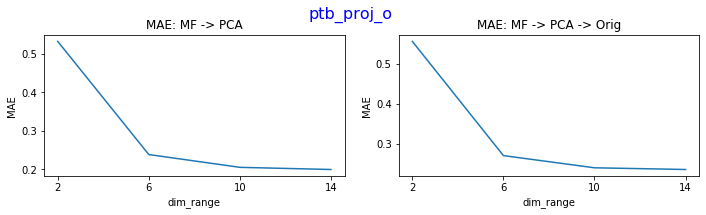

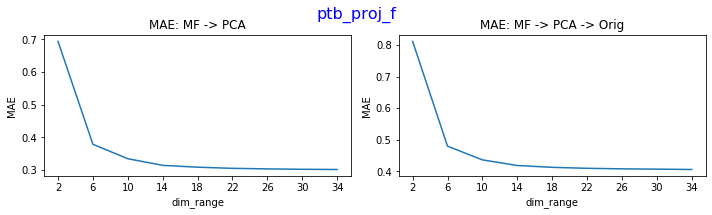

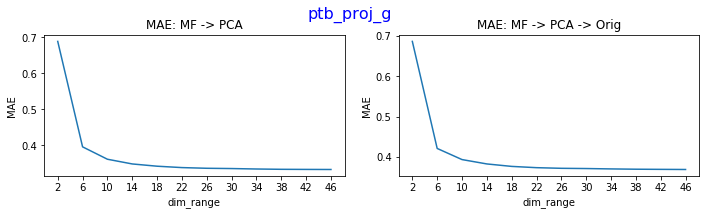

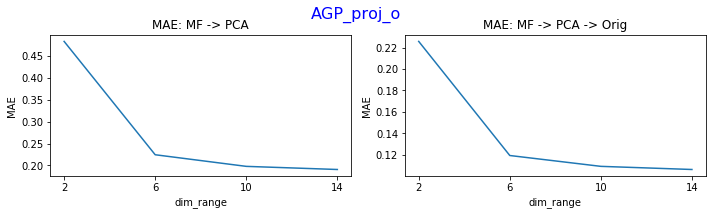

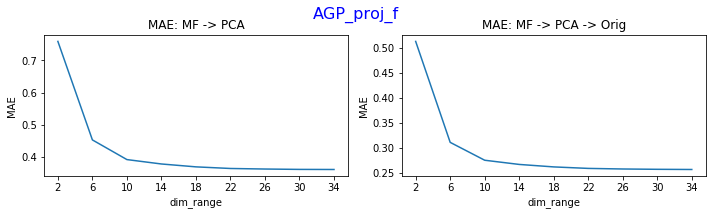

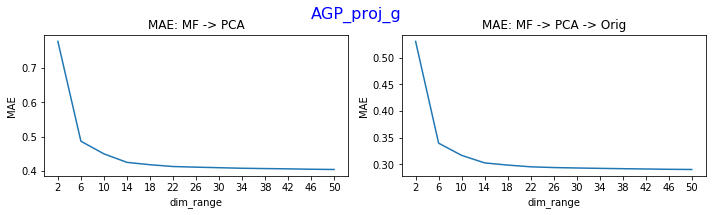

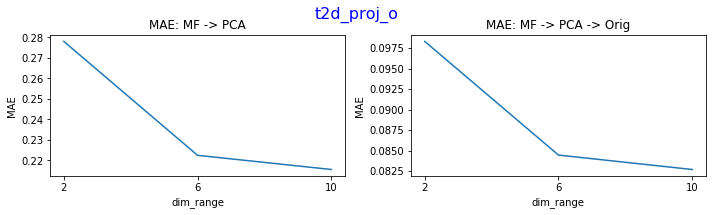

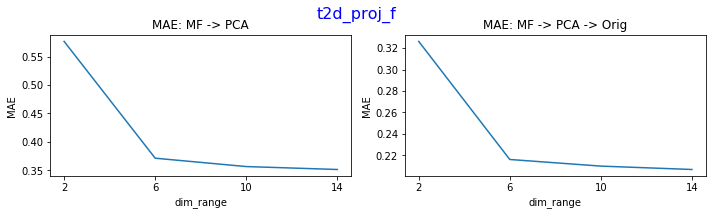

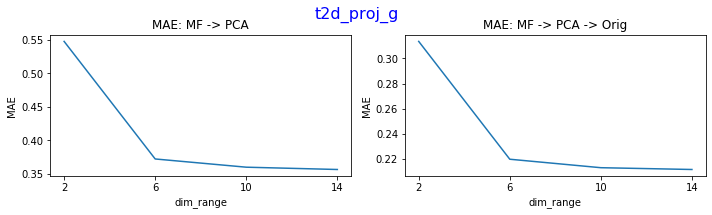

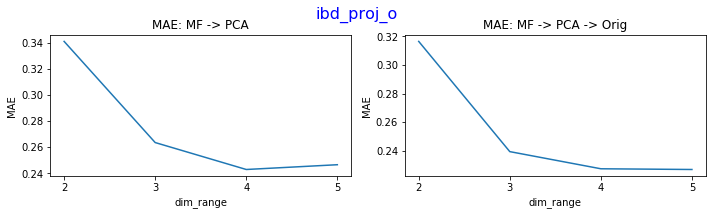

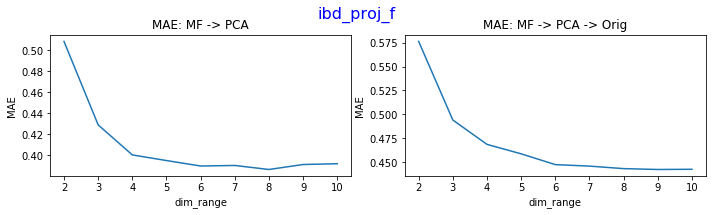

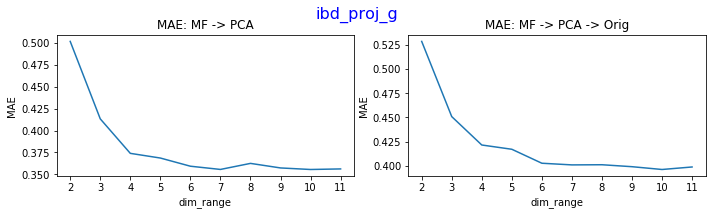

In [74]:
for i,dataset_name in tqdm_notebook(enumerate(['ptb', 'AGP', 't2d', 'ibd'])):
    for j,tax_name in enumerate(['o', 'f', 'g']):
        label = '_'.join([dataset_name, 'proj', tax_name])
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
        mdim = max_dims[label] 
        dim_range = np.arange(2,mdim, 1 if label[0] == 'i' else 4)
        
#         mf2pca_r2 = res_mf2pca_r2[label]
#         axes[0,0].plot(dim_range, mf2pca_r2)
#         axes[0,0].set_title('R2: MF -> PCA')
#         axes[0,0].set_xticks(ticks=dim_range)
#         axes[0,0].set_xticklabels(dim_range)
#         axes[0,0].set_xlabel('dim_range')
#         axes[0,0].set_ylabel('R2')
        
        mf2pca_mae = res_mf2pca_mae_nogs[label]
        axes[0].plot(dim_range, -np.array(mf2pca_mae))
        axes[0].set_title('MAE: MF -> PCA')
        axes[0].set_xticks(ticks=dim_range)
        axes[0].set_xticklabels(dim_range)
        axes[0].set_xlabel('dim_range')
        axes[0].set_ylabel('MAE')
        
#         inv_pca_mae = res_inv_pca_mae[label]

#         mf2pca2orig_r2 = res_mf2pca2orig_r2[label]
#         axes[1,0].plot(dim_range, mf2pca2orig_r2)
#         axes[1,0].set_title('R2: MF -> PCA -> Orig')
#         axes[1,0].set_xticks(ticks=dim_range)
#         axes[1,0].set_xticklabels(dim_range)
#         axes[1,0].set_xlabel('dim_range')
#         axes[1,0].set_ylabel('R2')
        
        mf2pca2orig_mae = res_mf2pca2orig_mae_nogs[label]
        axes[1].plot(dim_range, mf2pca2orig_mae)
        axes[1].set_title('MAE: MF -> PCA -> Orig')
        axes[1].set_xticks(ticks=dim_range)
        axes[1].set_xticklabels(dim_range)
        axes[1].set_xlabel('dim_range')
        axes[1].set_ylabel('MAE')
        
        fig.suptitle(label, fontsize=16, color='blue')
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        
        plt.savefig(f'./images/re_{label}')
        
        